# Lesson 2 : LangGraph Components

In [8]:
from dotenv import load_dotenv
_ = load_dotenv()

In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch


In [10]:
tool = TavilySearch(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_tavily.tavily_search.TavilySearch'>
tavily_search


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [11]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [12]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [13]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [94 lines of output]
      C:\Users\dtrun\AppData\Local\Temp\pip-build-env-52ti68im\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **********************************************

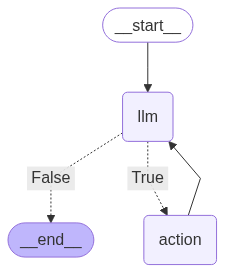

In [18]:
%pip install pygraphviz

from IPython.display import Image

Image(abot.graph.get_graph().draw_mermaid_png())

In [19]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search', 'args': {'query': 'current weather San Francisco', 'topic': 'general'}, 'id': 'call_QETZqFoSEYC9W7JUjzSlBhCs', 'type': 'tool_call'}
Back to the model!


In [20]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QETZqFoSEYC9W7JUjzSlBhCs', 'function': {'arguments': '{"query":"current weather San Francisco","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1340, 'total_tokens': 1363, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C28Z7pcWk0CHQQJnW2iYzAs916W8N', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--605be84b-6435-4a71-b5da-1cb6fe16b56b-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current weather

In [21]:
result['messages'][-1].content

'The current weather in San Francisco is as follows:\n\n- **Temperature**: 61°F (16.1°C)\n- **Condition**: Partly cloudy\n- **Wind**: 10.3 mph, coming from the west-southwest\n- **Humidity**: 87%\n- **Visibility**: 9 miles\n- **Pressure**: 29.95 in Hg\n\nFor more details, you can visit [WeatherAPI](https://www.weatherapi.com/).'

In [22]:
messages = [HumanMessage(content="What is the weather in Saigon, Vietnam?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search', 'args': {'query': 'current weather in Saigon, Vietnam', 'search_depth': 'basic'}, 'id': 'call_NXzBCMQwL8582CMcWJUNAPOw', 'type': 'tool_call'}
Back to the model!


In [23]:
result['messages'][-1].content

'The current weather in Saigon (Ho Chi Minh City), Vietnam is as follows:\n\n- **Temperature**: 33.2°C (91.8°F)\n- **Condition**: Partly cloudy\n- **Wind**: 5.6 mph (9.0 kph) from the west\n- **Humidity**: 63%\n- **Visibility**: 10 km (6 miles)\n- **Pressure**: 1011 mb\n- **Feels Like**: 36.3°C (97.3°F)\n\nFor more details, you can check out the following sources:\n- [Weather API](https://www.weatherapi.com/)\n- [AccuWeather](https://www.accuweather.com/en/vn/ho-chi-minh-city/8-353981_1_al/august-weather/8-353981_1_al)\n- [Weather Underground](https://www.wunderground.com/weather/vn/ho-chi-minh-city)\n- [Time and Date](https://www.timeanddate.com/weather/vietnam/ho-chi-minh/ext)'

In [24]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2026? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o-mini")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search', 'args': {'query': 'Super Bowl 2026 winner'}, 'id': 'call_oHdPbGf7Rg9yLue7PFfAfZr5', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search', 'args': {'query': 'Super Bowl LX winner 2026'}, 'id': 'call_bXlQHPUXAHLpdRZIrCHVXfKA', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search', 'args': {'query': 'Philadelphia Eagles headquarters location'}, 'id': 'call_JNaJ5Y7T0iGBJ6gaXW8fZpiV', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search', 'args': {'query': 'Pennsylvania GDP 2026'}, 'id': 'call_YKXNv7b1wuHltTJ9vvHkQm03', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)